In [1]:
%reload_ext autoreload
%autoreload 2

In [27]:
import os
import logging
from pathlib import Path

import arviz as az
import pandas as pd
import numpy as np
import numpyro

from hb_mep.config import HBMepConfig
from hb_mep.data_access import DataClass
from hb_mep.models.relu import ReLU
from hb_mep.models.rectified_logistic import RectifiedLogistic
from hb_mep.utils import plot

numpyro.set_platform("cpu")
numpyro.set_host_device_count(12)
numpyro.enable_x64()

PARENT_PATH = Path(os.getcwd()).parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

#### Load config

In [28]:
config = HBMepConfig()
config.CURRENT_PATH = PARENT_PATH

#### Load data and preprocess

In [29]:
data = DataClass(config)

DATASET_REAL = 'real_data/dnc_info_2022-05-26.parquet'
DATASET_REAL_METADATA = 'dnc_info_2022-05-26_settings.json'

df = pd.read_parquet(os.path.join(data.data_path, DATASET_REAL))
df = data.clean_human_data(df)

# participants = ["cornptio012", "cornptio013", "cornptio015", "scapptio001"]
# idx = df.participant.isin(participants)
# df = df[idx].reset_index(drop=True).copy()

df, encoder_dict = data.build(df)

2023-05-19 14:36:31,574 - hb_mep.utils.utils - INFO - func:clean_human_data took: 0.08 sec
2023-05-19 14:36:31,575 - hb_mep.data_access.core - INFO - Processing data ...
2023-05-19 14:36:31,583 - hb_mep.utils.utils - INFO - func:preprocess took: 0.01 sec
2023-05-19 14:36:31,583 - hb_mep.utils.utils - INFO - func:build took: 0.01 sec


### Rectified Linear

#### Initialize model

In [30]:
model_relu = ReLU(config)

#### Run MCMC inference

In [31]:
mcmc_relu, posterior_samples_relu = model_relu.run_inference(df=df)

2023-05-19 14:36:37,880 - hb_mep.models.relu - INFO - Running inference with ReLU ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-05-19 14:41:48,471 - hb_mep.utils.utils - INFO - func:run_inference took: 5 min and 10.59 sec


#### Diagnostics

In [32]:
mcmc_relu.print_summary(prob=.95)


                             mean       std    median      2.5%     97.5%     n_eff     r_hat
                 a[0,0]      0.98      0.87      0.82      0.00      2.19   1662.46      1.00
                 a[0,1]      1.10      0.15      1.11      0.80      1.39   6091.38      1.00
                 a[0,2]      2.78      1.42      3.04      0.00      4.75   2382.16      1.00
                 a[0,3]      3.77      0.31      3.77      3.18      4.39   5101.10      1.00
                 a[0,4]      2.65      0.58      2.57      1.97      3.26    795.81      1.00
                 a[0,5]      4.87      3.47      4.50      0.00     10.28   3054.16      1.00
                 a[0,6]      2.90      0.11      2.91      2.74      3.08   1320.15      1.00
                 a[0,7]      1.44      0.17      1.47      1.03      1.71   4652.63      1.00
                 a[0,8]      1.07      0.33      1.07      0.02      1.62     38.29      1.12
                 a[0,9]      1.99      0.24      1.89      

#### Plot fitted curves

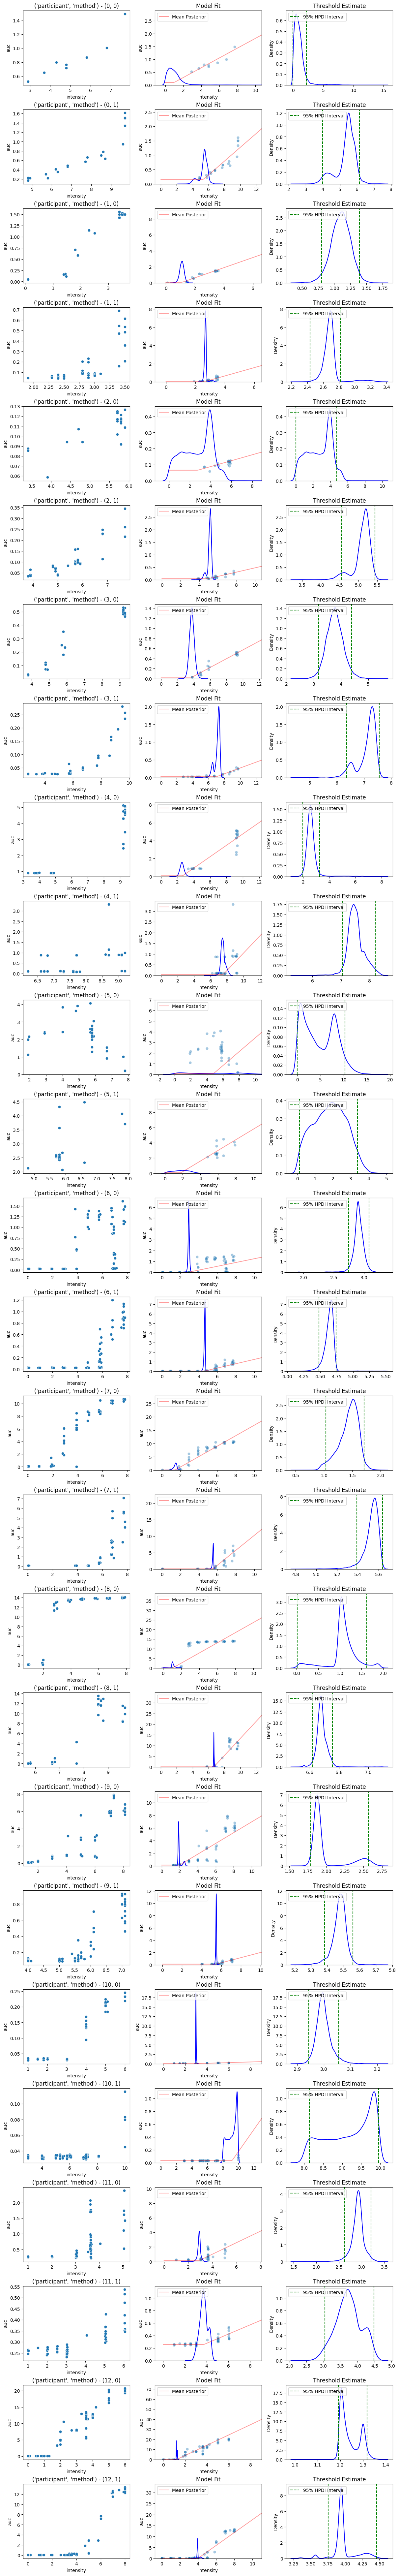

In [33]:
model_relu.plot(df=df, posterior_samples=posterior_samples_relu);

#### Information Criterion

In [34]:
numpyro_data_relu = az.from_numpyro(mcmc_relu)

##### Loo

In [35]:
az.loo(numpyro_data_relu)

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 24000 posterior samples and 1165 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   724.13    89.56
p_loo      174.16        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1102   94.6%
 (0.5, 0.7]   (ok)         24    2.1%
   (0.7, 1]   (bad)         8    0.7%
   (1, Inf)   (very bad)   31    2.7%

##### WAIC

In [36]:
az.waic(numpyro_data_relu)

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 24000 posterior samples and 1165 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   740.92    88.59
p_waic      157.37        -

There has been a warning during the calculation. Please check the results.

### Rectified Logistic

#### Initialize model

In [5]:
model_rectified_logistic = RectifiedLogistic(config)

#### Run MCMC inference

In [6]:
mcmc_rectified_logistic, posterior_samples_rectified_logistic = \
    model_rectified_logistic.run_inference(df=df)

2023-05-19 14:05:27,038 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2023-05-19 14:05:27,039 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-19 14:05:27,039 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-19 14:05:27,039 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-05-19 14:05:27,040 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2023-05-19 14:05:27,073 - hb_mep.models.rectified_logistic - INFO - Running inference with Rectifie

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-05-19 14:16:08,062 - hb_mep.utils.utils - INFO - func:run_inference took: 10 min and 41.03 sec


#### Diagnostics

In [7]:
mcmc_rectified_logistic.print_summary(prob=.95)


                             mean       std    median      2.5%     97.5%     n_eff     r_hat
                 a[0,0]      0.99      1.10      0.69      0.00      2.78   5337.65      1.00
                 a[0,1]      1.37      0.09      1.36      1.22      1.55   4204.21      1.00
                 a[0,2]      2.96      1.44      3.32      0.01      4.97   2283.82      1.00
                 a[0,3]      4.31      0.40      4.37      3.39      5.20   2072.12      1.00
                 a[0,4]      1.20      0.54      1.16      0.37      2.06   1122.91      1.00
                 a[0,5]      0.85      0.96      0.69      0.00      1.70   1019.01      1.00
                 a[0,6]      3.14      0.14      3.12      2.90      3.42  12380.09      1.00
                 a[0,7]      1.81      0.25      1.80      1.34      2.33   3477.44      1.00
                 a[0,8]      1.96      0.04      1.96      1.90      2.04   3506.52      1.00
                 a[0,9]      1.71      0.08      1.72      

#### Plot fitted curves

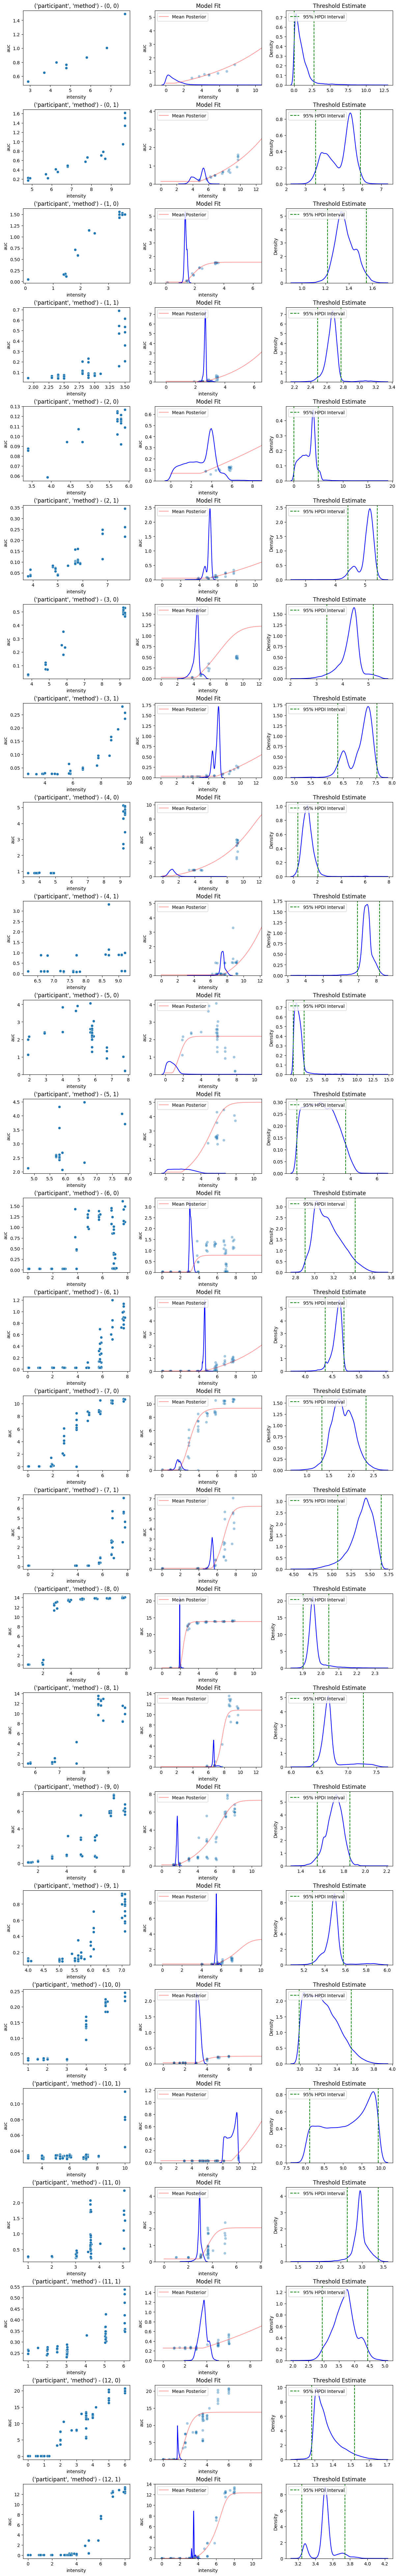

In [18]:
model_rectified_logistic.plot(df=df, posterior_samples=posterior_samples_rectified_logistic);

#### Information Criterion

In [8]:
numpyro_data_rectified_logistic = az.from_numpyro(mcmc_rectified_logistic)

##### Loo

In [9]:
az.loo(numpyro_data_rectified_logistic)

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 24000 posterior samples and 1165 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   943.20    88.24
p_loo      202.71        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1109   95.2%
 (0.5, 0.7]   (ok)         27    2.3%
   (0.7, 1]   (bad)        19    1.6%
   (1, Inf)   (very bad)   10    0.9%

##### WAIC

In [10]:
az.waic(numpyro_data_rectified_logistic)

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 24000 posterior samples and 1165 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   964.83    86.72
p_waic      181.09        -

There has been a warning during the calculation. Please check the results.

#### Model Comparison

In [37]:
az.compare({
    "ReLU": numpyro_data_relu,
    "Rectified_Logistic": numpyro_data_rectified_logistic
})

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
 

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Rectified_Logistic,0,943.202670,202.711956,0.000000,0.92893,88.243251,0.000000,True,log
ReLU,1,724.134132,174.158801,219.068538,0.07107,89.560215,30.637239,True,log
